objetivo do notebook: fazer classificacao usando CNN (rede neural convolucional) ao invés de camadas lineares

Uma camada convulacional é equivariante, o que significa que se o objeto da imagem for transladado, o resultado da convolucao sera transladado da mesma quantia; mesmo filtro aprendido pela rede podera ser utilizado independente de onde estiver o objeto na imagme

Porem, deseja-se que a rede de classificacao seja invariante, ou seja, que ela retorne um mesmo valor final independente de onde o objeto estiver na imagem. Para isso, usa-se uma camada de max pooling global, que recebe como entrada o resultado da convolucao e retorna um unico valor, dado pelo maior valor da resposta de cada filtro da camada de convolucao

In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from dataset import load_mnist
import train
import torch.nn.functional as F

ds_train, ds_valid = load_mnist()

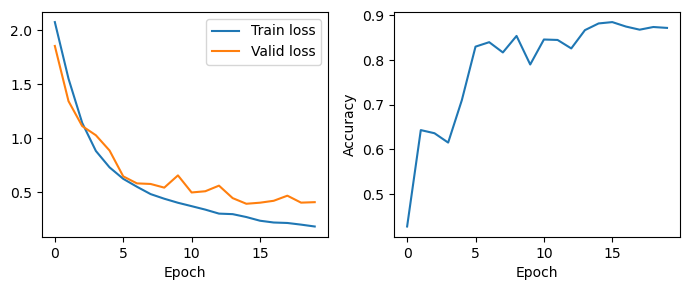

CPU times: user 36.5 s, sys: 324 ms, total: 36.8 s
Wall time: 18.7 s


In [3]:
%%time
class Model(nn.Module):

    # o que acontece abaixo: input channel eh 1 pois uma imagem de um canal entra
    # convolucao gera 12 saidas (a partir da convolucao com 12 filtros difernetes)
    # sendo que cada resultado da convolucao tem mesmo tamanho da imagem
    # AdaptiveMaxPool2d definido com output_size=1 reduz matriz a um valor, o maior
    # deles
    # camada linear fc recebe 12 valores de entrada e gera 10 de saida
    def __init__(self):
        super().__init__()
        # 1 canal de entrada, 12 filtros de saida
        # ks=13 indica tamanho do filtro
        # padding ks//2 indica que saida tera mesmo tamanho que entrada, preenchimento automatico de zeros 
        # eh feito 
        self.conv = nn.Conv2d(1, 12, kernel_size=13, padding=13//2)

        # na pratica retorna matriz 1x1
        self.pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Linear(12, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        # Transformação do tensor de tamanho bs x 12 x 1 x 1 para bs x 12
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

model = Model()
logger = train.train(model, ds_train, ds_valid, bs=8, num_epochs=20, lr=0.01)


teste (ignorar)

In [4]:
img = torch.ones(size=(1, 1, 2,2))
conv = nn.Conv2d(1, 2, kernel_size=2, padding=2//2)
# print(img, conv.weight)
print(img[0, 0, :, 0])
# print((conv.weight[0]*img[0, 0, :, 0]).sum())
conv(img)

tensor([1., 1.])


tensor([[[[-0.1230,  0.1372, -0.1456],
          [-0.3752, -0.4939, -0.5245],
          [-0.6581, -1.0369, -0.7847]],

         [[-0.5935, -0.2415, -0.0308],
          [-0.6817, -0.4434, -0.1445],
          [-0.4710, -0.5846, -0.4964]]]], grad_fn=<ConvolutionBackward0>)

In [5]:
# salvamento da rede treinada
checkpoint = {
    'params':{
        'bs':8,
        'num_epochs':20,
        'lr':0.01
    },
    'model':model.state_dict()
}
torch.save(checkpoint, '../data/checkpoints/M04/mnist_model.pt')

RuntimeError: Parent directory ../data/checkpoints/M04 does not exist.

In [ ]:
# carregar rede de volta do disco

checkpoint = torch.load('../data/checkpoints/M04/mnist_model.pt')
model = Model()
model.load_state_dict(checkpoint['model'])


NameError: name 'torch' is not defined

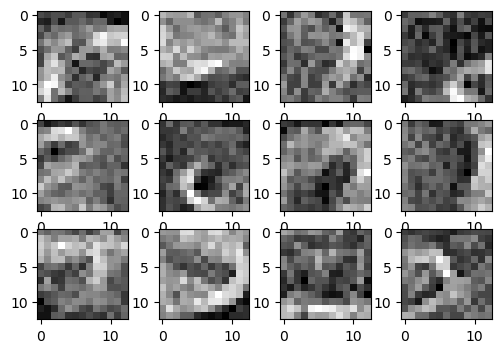

In [6]:
# visualizacao de cada filtro da rede 
fig, axs = plt.subplots(3, 4, figsize=(6,4))
axs = axs.reshape(-1)
for idx in range(12):
    axs[idx].imshow(model.conv.weight[idx,0].detach(), 'gray')

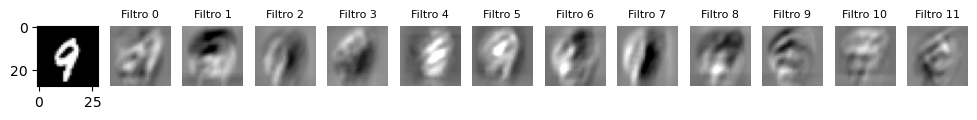

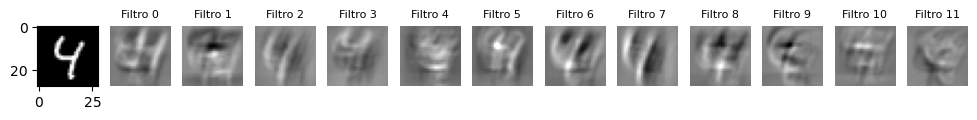

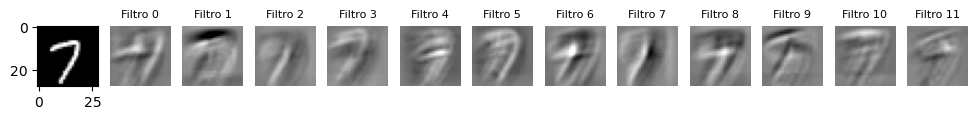

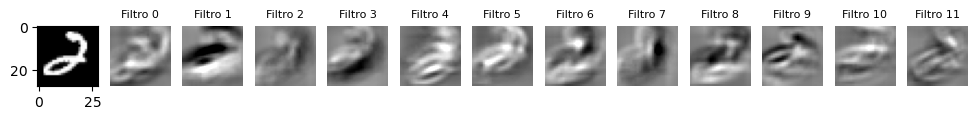

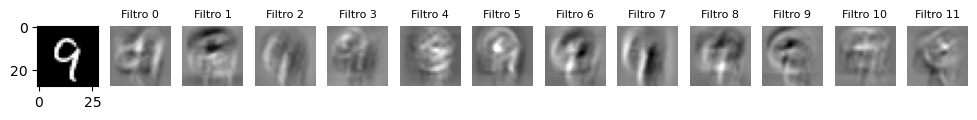

In [7]:
# aplicacao de 5 imagens e visualizacao da resposta para cada filtro

# Cria um batch de 5 imagens
n = 5
batch = torch.stack([ds_train[idx][0] for idx in range(n)])
# Aplica apenas a camada de convolução no batch
with torch.no_grad():
    res = model.conv(batch)

# visualiza os 10 resultados para cada imagem
for idx in range(n):
    fig, axs = plt.subplots(1,13, figsize=(12,3))
    axs[0].imshow(batch[idx,0], 'gray')
    for channel in range(12):
        ax = axs[channel+1]
        ax.imshow(res[idx,channel], 'gray', vmin=-10, vmax=10)
        ax.set_title(f'Filtro {channel}', size=8)
        ax.set_axis_off()